# RADAR Reflectivity Download and Interpretation

In [1]:
import numpy as np

In [2]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin

base_url = "https://opendata.dwd.de/weather/radar/composite/hx/"
response = requests.get(base_url)
soup = BeautifulSoup(response.text, "html.parser")

# Filter for hd5 files
hd5_files = sorted([
    a.get("href") for a in soup.find_all("a")
    if "composite_hx" in a.get("href", "") and "-hd5" in a.get("href", "")
])

if hd5_files:
    latest_file = hd5_files[-1]
    download_url = urljoin(base_url, latest_file)
    print(f"Downloading: {latest_file}")

    r = requests.get(download_url)
    with open("radar.h5", "wb") as f:
        f.write(r.content)

    print("✅ Download complete: saved as 'radar.h5'")
else:
    print("⚠️ No suitable .hd5 files found in /hx/")


Downloading: composite_hx_LATEST-hd5
✅ Download complete: saved as 'radar.h5'


In [3]:
import h5py

with h5py.File("radar.h5", "r") as f:
    print("📁 Groups and datasets in radar.h5:")
    f.visit(lambda name: print(" -", name))
    
    # Try accessing a key dataset
    if "image1/image_data" in f:
        data = f["image1/image_data"][:]
        print("✅ Reflectivity data shape:", data.shape)
    else:
        print("⚠️ 'image1/image_data' not found — structure may differ.")


📁 Groups and datasets in radar.h5:
 - dataset1
 - dataset1/data1
 - dataset1/data1/data
 - dataset1/data1/what
 - dataset1/how
 - dataset1/how/POLARA
 - dataset1/what
 - dataset1/where
 - how
 - how/POLARA
 - what
 - where
⚠️ 'image1/image_data' not found — structure may differ.


In [4]:
import h5py

with h5py.File("radar.h5", "r") as f:
    reflectivity = f["dataset1/data1/data"][:]
    print("Reflectivity shape:", reflectivity.shape)
    print("Min/Max values:", reflectivity.min(), reflectivity.max())


Reflectivity shape: (4800, 4400)
Min/Max values: 0 65535


In [5]:
with h5py.File("radar.h5", "r") as f:
    what = f["dataset1/data1/what"]
    gain = what.attrs.get("gain", 1.0)
    offset = what.attrs.get("offset", 0.0)
    undetect = what.attrs.get("undetect", None)

    print(f"Gain: {gain}, Offset: {offset}, Undetect value: {undetect}")

    reflectivity = reflectivity * gain + offset
    if undetect is not None:
        reflectivity[reflectivity == undetect] = np.nan

Gain: 0.002929821616590115, Offset: -64.00292982161659, Undetect value: 0.0


In [6]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Load and decode reflectivity field
with h5py.File("radar.h5", "r") as f:
    raw = f["dataset1/data1/data"][:]
    what = f["dataset1/data1/what"]
    gain = what.attrs.get("gain", 1.0)
    offset = what.attrs.get("offset", 0.0)
    undetect = what.attrs.get("undetect", 65535)  # default fallback

    print(f"Gain: {gain}, Offset: {offset}, Undetect: {undetect}")
    
    # Apply scaling and masking
    # Convert to float and apply gain/offset
    data = raw.astype(np.float32) * gain + offset
    
    # Mask missing values properly
    data[(raw == 65535) | (raw == 0) | (data < 0)] = np.nan

# Preview
print("Scaled data range:", np.nanmin(data), "to", np.nanmax(data))

Gain: 0.002929821616590115, Offset: -64.00292982161659, Undetect: 0.0
Scaled data range: 0.019532144110598892 to 34.462515068744


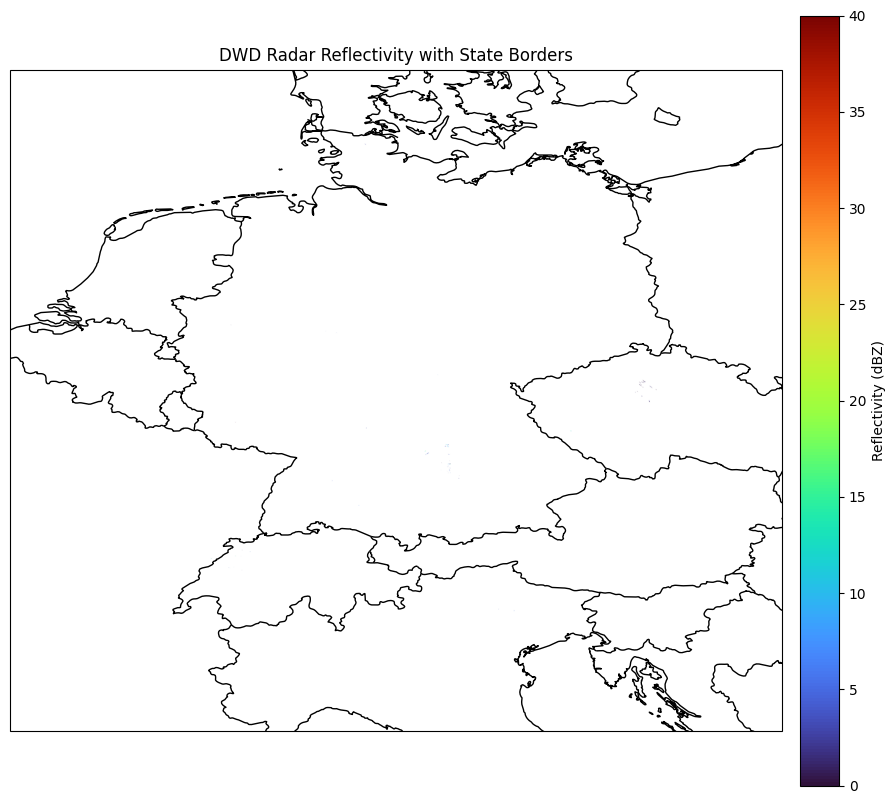

In [7]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import colormaps
import numpy as np

cmap = colormaps.get_cmap("turbo").copy()
cmap.set_bad(color='white')  # Set white background for NaNs

masked_data = np.ma.masked_invalid(data)

# Mask the data properly
masked_data = np.ma.masked_invalid(data)

# Define extent for Germany
extent = [3.0, 17.0, 44.0, 56.0]

# Plot
plt.figure(figsize=(12, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(extent, crs=ccrs.PlateCarree())

im = ax.imshow(masked_data, extent=extent, origin='lower',
               cmap=cmap, vmin=0, vmax=40, transform=ccrs.PlateCarree())

# Add features
cbar = plt.colorbar(im, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label("Reflectivity (dBZ)")
ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
ax.coastlines(resolution='10m')
ax.set_title("DWD Radar Reflectivity with State Borders")

# Save correctly
plt.savefig("radar_map_germany.png", dpi=150)
plt.show()


In [8]:
unique_values = np.unique(raw)
print("Unique raw values (sample):", unique_values[20:])
print("Min:", raw.min(), "Max:", raw.max())


Unique raw values (sample): [13303 13311 13340 ... 33377 33608 65535]
Min: 0 Max: 65535


In [9]:
from openai import OpenAI
from dotenv import load_dotenv
import os
import base64
from IPython.display import Markdown, display

# Load API key
load_dotenv()
client = OpenAI(api_key=os.getenv("OPENAI_API_KEY"))

# Encode the radar image as base64
image_path = "radar_map_germany.png"
with open(image_path, "rb") as image_file:
    base64_image = base64.b64encode(image_file.read()).decode("utf-8")

# Call GPT-4 Turbo with Vision
response = client.chat.completions.create(
    model="gpt-4-turbo",
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "Please interpret this radar reflectivity image from Germany. Describe precipitation areas, dBZ intensity ranges, and identify convective or stratiform structures."
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/png;base64,{base64_image}"
                    }
                }
            ]
        }
    ],
    max_tokens=800,
)

# Display as Markdown in notebook
interpretation = response.choices[0].message.content
display(Markdown(interpretation))


This image of radar reflectivity from Germany depicts various levels of precipitation intensity across different regions, as indicated by the color scale on the right. The color scale ranges from 0 dBZ, representing no precipitation, to 40 dBZ, indicating heavy precipitation.

In this image:

1. **Northwestern Germany**: There appears to be no significant precipitation as the colors are in the lower range of the scale (0-5 dBZ), which is indicative of clear or very light precipitation conditions.

2. **Northeastern Germany**: Similar to the northwest, this region also shows minimal reflectivity values, indicating little to no precipitation.

3. **Central and Southern Germany**: These areas also display minimal radar reflectivity with dBZ values primarily in the range of 0-5 dBZ. There seem to be no significant precipitation events occurring in these regions at the time this image was captured.

4. **Western and Southwestern Germany**: These regions are predominantly clear, with a few areas perhaps having very light precipitation as indicated by slightly higher, but still minimal dBZ values.

There are no distinct areas of high dBZ values (e.g., >20 dBZ) that would suggest moderate to heavy rainfall or convective activity (such as thunderstorms) anywhere on the map. Therefore, the image overall does not show any signs of significant convective structures such as thunderstorm cells, which would typically be indicated by localized, high-intensity dBZ readings.

All in all, the weather across Germany during the period represented by this reflectivity image seems to be largely calm and free of significant precipitation events, with only scattered, very light precipitation or clear conditions throughout. The absence of any high dBZ values indicates an absence of strong convective activities like thunderstorms, which are typically characterized by sudden, intense rainfall indicated by higher dBZ values.

In [10]:
print(interpretation)

This image of radar reflectivity from Germany depicts various levels of precipitation intensity across different regions, as indicated by the color scale on the right. The color scale ranges from 0 dBZ, representing no precipitation, to 40 dBZ, indicating heavy precipitation.

In this image:

1. **Northwestern Germany**: There appears to be no significant precipitation as the colors are in the lower range of the scale (0-5 dBZ), which is indicative of clear or very light precipitation conditions.

2. **Northeastern Germany**: Similar to the northwest, this region also shows minimal reflectivity values, indicating little to no precipitation.

3. **Central and Southern Germany**: These areas also display minimal radar reflectivity with dBZ values primarily in the range of 0-5 dBZ. There seem to be no significant precipitation events occurring in these regions at the time this image was captured.

4. **Western and Southwestern Germany**: These regions are predominantly clear, with a few a